In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import copy
import itertools
import json
import math
import os

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [34]:
from collections import defaultdict

In [5]:
from data.pascalvoc.preprocessing.utils import load_ids
from data.pascalvoc.pascalvoc import PascalVOC

Using TensorFlow backend.


In [6]:
from model.networks.baseline_logits import BaselineLogits

In [7]:
from model import relabel
from model import priors

In [8]:
class_info = load_ids()
id2name = {int(info['id']): info['name'] for info in class_info.values()}

In [9]:
data_dir = '/home/caleml/datasets/pascalvoc/VOCdevkit/VOC2007/'
weights_path = '/home/caleml/partial_experiments/exp_20191009_1546_baseline_logits/weights_10_015_00.h5'
gt_path = os.path.join(data_dir, 'Annotations', 'annotations_multilabel_trainval_partial_100_1.csv')
config_path = '/home/caleml/partial-labels/config/pv_relabel_pfull.yaml'
config_path2 = '/home/caleml/partial-labels/config/pv_relabel_pcoco_alpha.yaml'
# prior_path = '/home/caleml/datasets/mscoco/annotations/multilabel_train2014_partial_100_1.json'
prior_path = os.path.join(data_dir, 'Annotations', 'prior_matrix_coco14_partial_100_1.json')

In [10]:
batch_size = 16
nb_classes = 20
prop = 10

In [11]:
# load dataset
dataset_train = PascalVOC(data_dir, batch_size, 'trainval', x_keys=['image', 'image_id'], y_keys=['multilabel'], p=prop)

In [12]:
# load model
model = BaselineLogits('%s/partial_experiments/' % os.environ['HOME'], nb_classes, prop)
model.load_weights(weights_path)

Init input_shape (448, 448, 3)
Loading options
{'ARCHI': {'CLASSIFIER': 'resnet50', 'LOSS': 'bce', 'NAME': 'baseline_logits'},
 'BATCH_SIZE': 16,
 'CALLBACK': {'LR_FACTOR': 0.1,
              'LR_TRIGGER': [],
              'MIN_DELTA': 0.0,
              'PATIENCE': 10,
              'PATIENCE_LR': 2,
              'TENSORBOARD': {'SAVE_GRAPH': True, 'USE_TENSORBOARD': False},
              'VAL_CB': 'map'},
 'CLEANUP': False,
 'DATAAUGMENTATION': {'DEFAULT_DICT': {'HORIZONTAL_FLIP': True,
                                       'horizontal_flip': True}},
 'DATASET': {'NAME': 'pascalvoc',
             'PATH': '/home/caleml/datasets/pascalvoc/VOCdevkit/VOC2007/',
             'SHUFFLE': True,
             'TEST': 'test',
             'TRAIN': 'trainval'},
 'DEBUG': {'IS_TEST': False},
 'EPSILON': 1e-07,
 'IMAGE': {'IMG_SIZE': 448, 'N_CHANNELS': 3},
 'MULTIP': {'MAX_QUEUE_SIZE': 10, 'N_WORKERS': 2, 'USE_MULTIPROCESS': False},
 'RANDOM_SEED': 1,
 'RELABEL': {'ACTIVE': True,
             '

/home/caleml/partial-labels/model/networks/__init__.py:39: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  loaded_conf = yaml.load(f_in)


Outputs shape [(None, 20), (None, 20)]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
reduction_indices is deprecated, use axis instead
Final model summary
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
cls_model (Model)               (None, 14, 14, 2048) 23587712    image_input[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           cls_model[1][0]                  
______________________________________________________________

In [13]:
prior = priors.ConditionalPrior(prior_path, nb_classes=nb_classes, prior_type='coco')

loading conditional prior with prior_type coco and method product


In [14]:
# sigmoid to logit function
def get_logits(values):
    '''
    values are (batch_size, nb_classes) size
    ln (p / 1-p)
    '''
    assert values.shape == (batch_size, nb_classes)
    return np.log(values / (1 - values))

In [15]:
data_yv_logits = defaultdict(list)
data_yp0_logits = defaultdict(list)
data_yp1_logits = defaultdict(list)

## gather data

In [16]:
# loop over dataset
for i_batch in range(len(dataset_train)):
    if i_batch % 100 == 0:
        print('doing batch %s' % i_batch)
        
    x_batch, y_batch = dataset_train[i_batch]
    y_true = y_batch[0]
    assert y_true.shape == (batch_size, nb_classes)

    # predict (we get y_v logits)
    y_pred = model.predict(x_batch)   # y_pred[0] -> y_v, y_pred[1] -> logits of y_v
    y_v_logits = np.asarray(y_pred[1])

    # compute prior (to get y_p)
    p_k = prior.compute_pk(y_true)
    assert p_k.shape == (batch_size, nb_classes, 2)
    
    # get the logit values of the prior
    p_k_logits_zeros = get_logits(p_k[:,:,0])
    p_k_logits_ones = get_logits(p_k[:,:,1])
    
    # store the ~y_v and ~y_p per class
    for i in range(nb_classes):
        cname = id2name[i]
        yv_logits_i = y_v_logits[:,i]
        assert yv_logits_i.shape == (batch_size,)
        
        data_yv_logits[cname].append(yv_logits_i)
        data_yp0_logits[cname].append(p_k_logits_zeros[:,i])
        data_yp1_logits[cname].append(p_k_logits_ones[:,i])


doing batch 0
doing batch 100
doing batch 200
doing batch 300


In [17]:
# concat
for i in range(nb_classes):
    cname = id2name[i]
    data_yv_logits[cname] = np.concatenate(data_yv_logits[cname])
    data_yp0_logits[cname] = np.concatenate(data_yp0_logits[cname])
    data_yp1_logits[cname] = np.concatenate(data_yp1_logits[cname])

In [18]:
# compute max, min, mean and stddev for each class
with open('/home/caleml/partial-labels/experiments/pascal_yv_logit_data2.csv', 'w+') as f_yv, \
    open('/home/caleml/partial-labels/experiments/pascal_yp0_logit_data2.csv', 'w+') as f_yp0, \
    open('/home/caleml/partial-labels/experiments/pascal_yp1_logit_data2.csv', 'w+') as f_yp1:
        
    f_yv.write('name,max,min,mean,stddev\n')
    f_yp0.write('name,max,min,mean,stddev\n')
    f_yp1.write('name,max,min,mean,stddev\n')
    
    for i in range(nb_classes):
        cname = id2name[i]
        yv_logits = data_yv_logits[cname]
        line = ','.join([cname, str(yv_logits.min()), str(yv_logits.max()), str(np.mean(yv_logits)), str(np.std(yv_logits))])
        f_yv.write(line + '\n')
        
        yp0_logits = data_yp0_logits[cname]
        line = ','.join([cname, str(yp0_logits.min()), str(yp0_logits.max()), str(np.mean(yp0_logits)), str(np.std(yp0_logits))])
        f_yp0.write(line + '\n')
        
        yp1_logits = data_yp1_logits[cname]
        line = ','.join([cname, str(yp1_logits.min()), str(yp1_logits.max()), str(np.mean(yp1_logits)), str(np.std(yp1_logits))])
        f_yp1.write(line + '\n')
        

In [23]:
# read data
def read_data(filepath):
    print('\nReading %s' % filepath.split('/')[-1])
    with open(filepath, 'r') as f_in:
        for line in f_in:
            print(line.strip())
            
        
read_data('/home/caleml/partial-labels/experiments/pascal_yv_logit_data2.csv')
read_data('/home/caleml/partial-labels/experiments/pascal_yp0_logit_data2.csv')
read_data('/home/caleml/partial-labels/experiments/pascal_yp1_logit_data2.csv')


Reading pascal_yv_logit_data2.csv
name,max,min,mean,stddev
aeroplane,-19.053644,18.056782,-10.124563,4.4648743
bicycle,-20.07928,28.73754,-9.766064,3.931765
bird,-23.394053,20.521942,-10.348666,5.1861687
boat,-23.063309,17.621292,-10.4153595,3.990749
bottle,-22.31327,21.797443,-9.724132,4.1709995
bus,-21.904781,17.123549,-10.079632,3.5811362
car,-21.106863,32.52003,-7.917916,6.5627465
cat,-20.260666,27.146866,-9.457972,4.1547728
chair,-24.380365,20.662418,-8.647549,5.3266373
cow,-22.529581,13.4544325,-10.403686,3.0127912
diningtable,-20.114132,17.154612,-9.875449,4.0108776
dog,-23.6242,26.009647,-9.287005,4.5971947
horse,-21.47047,27.451954,-9.575879,4.739205
motorbike,-21.525473,20.12704,-9.960575,4.0088844
person,-24.216303,30.640692,-2.1390116,9.07955
pottedplant,-22.2518,20.75615,-9.793421,3.8334281
sheep,-21.39353,8.445505,-10.494793,2.8062255
sofa,-23.772057,16.769148,-9.891427,4.319994
train,-22.939472,23.901482,-9.991183,4.7412777
tvmonitor,-23.084753,20.850239,-9.919717,4.272

## testing

In [ ]:
# test
a = np.random.random((5, 2))
print(a)
b = np.log(a / (1 - a))
print(b)

In [ ]:
b[:,0]

In [ ]:
v = 0.4258175
w = 1 - v
x = np.log(v / w)
x

## histograms

aeroplane


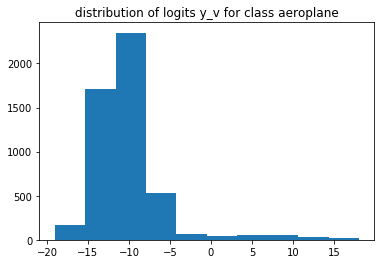

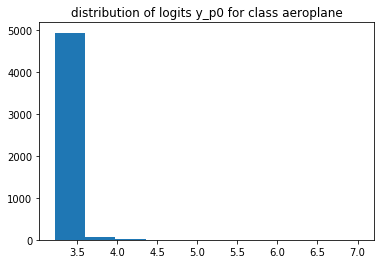

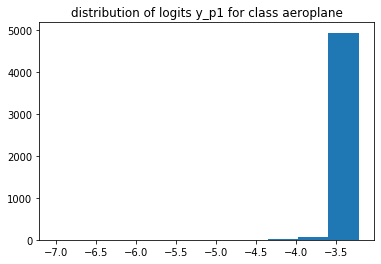

bicycle


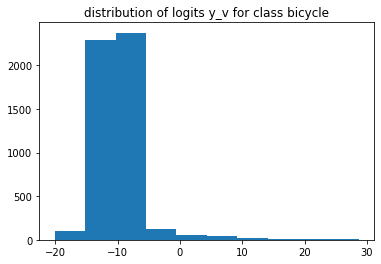

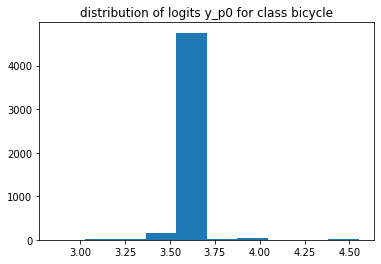

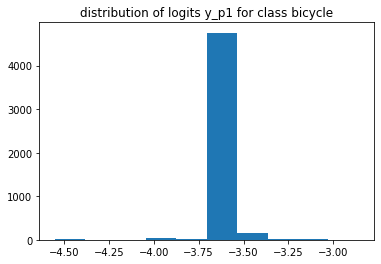

bird


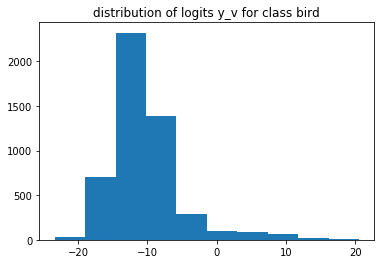

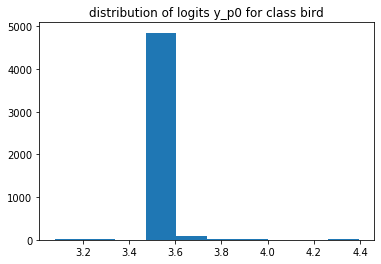

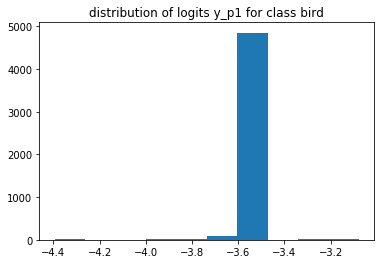

boat


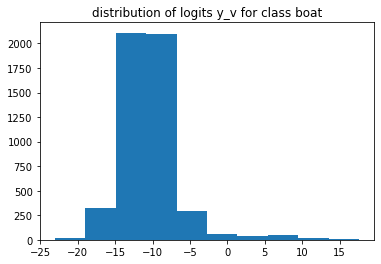

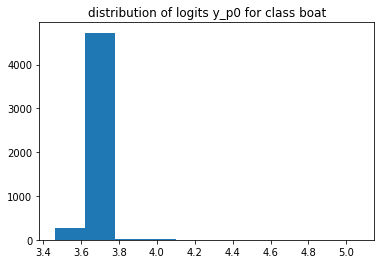

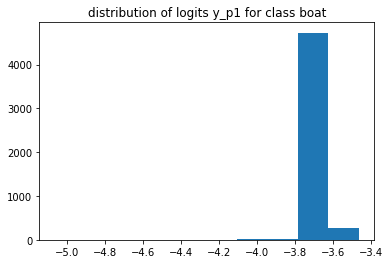

bottle


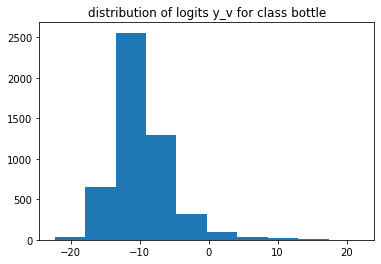

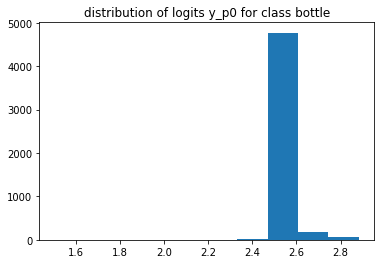

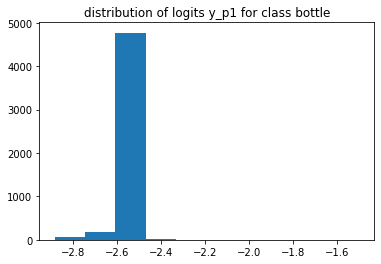

bus


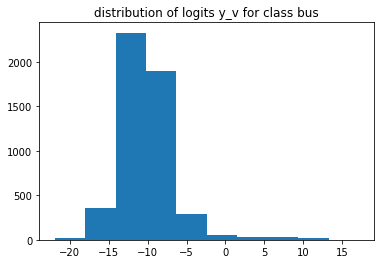

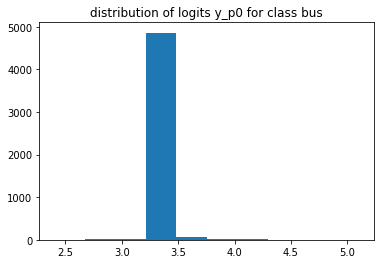

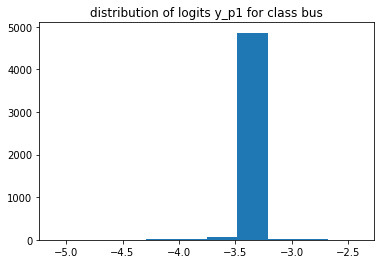

car


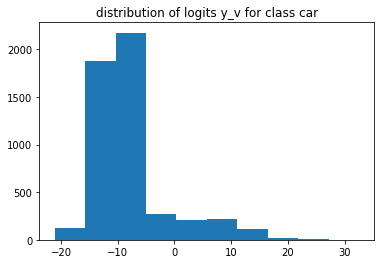

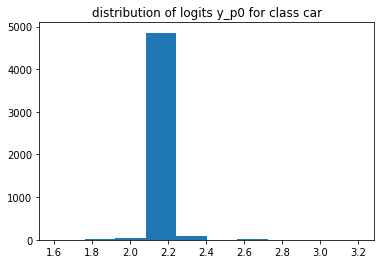

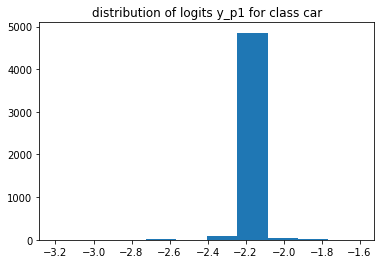

cat


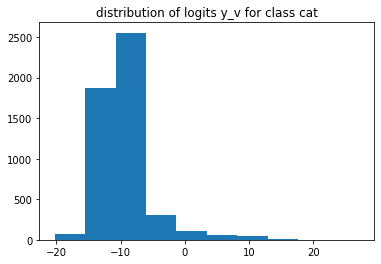

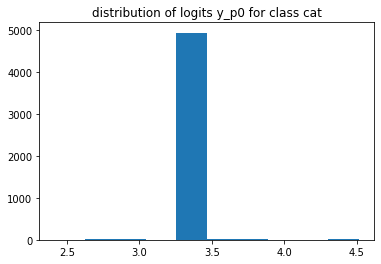

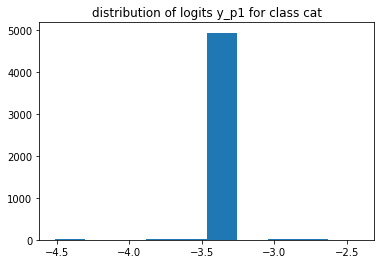

chair


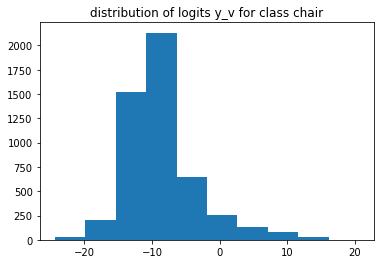

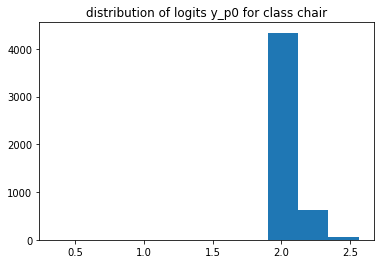

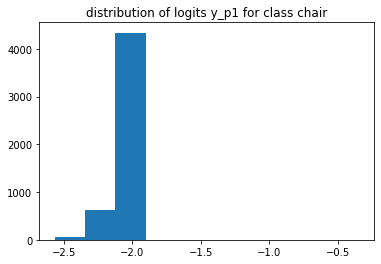

cow


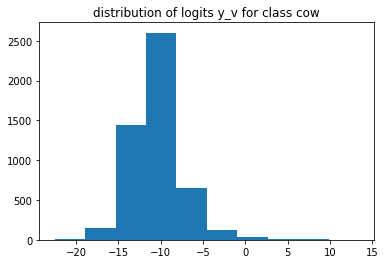

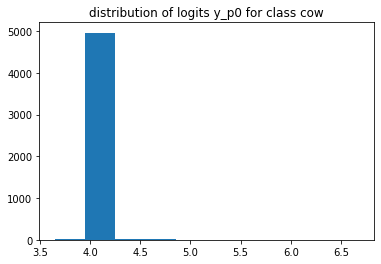

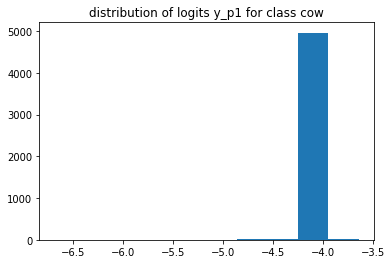

diningtable


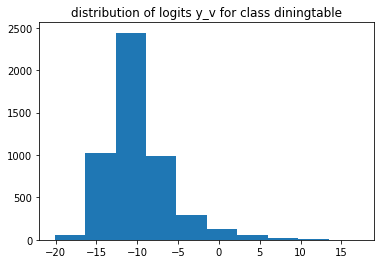

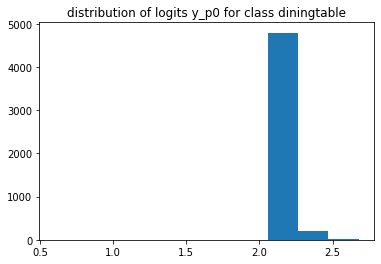

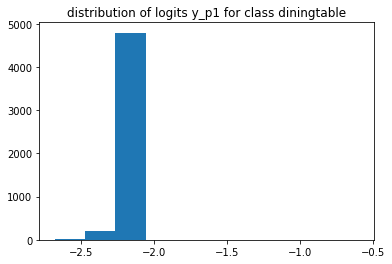

dog


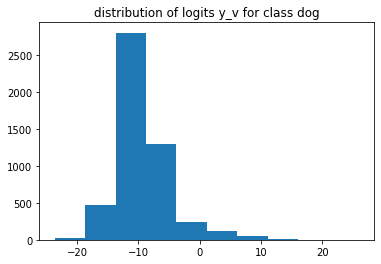

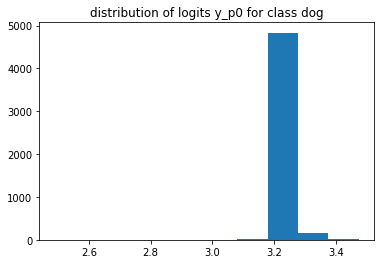

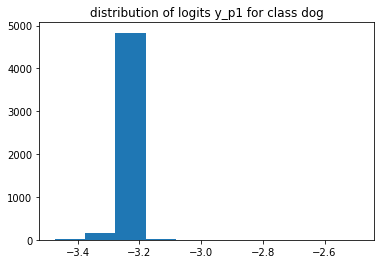

horse


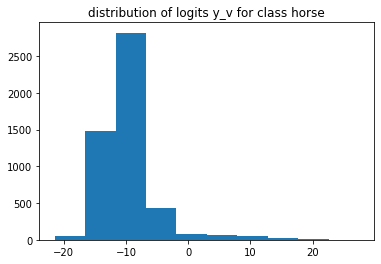

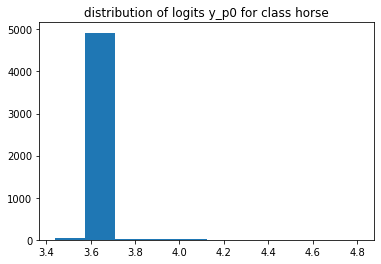

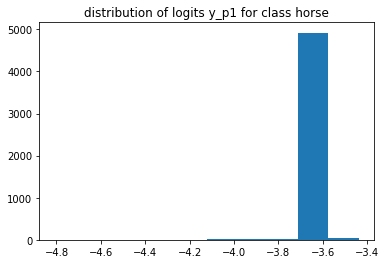

motorbike


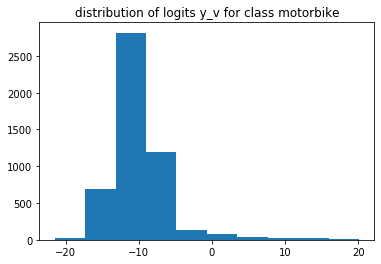

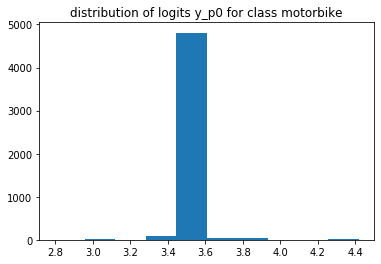

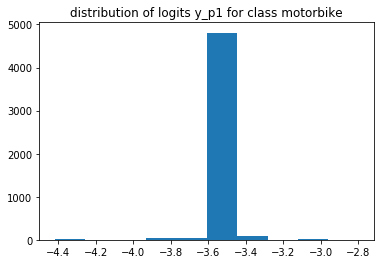

person


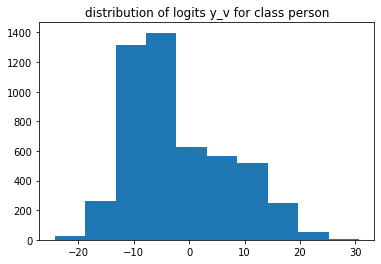

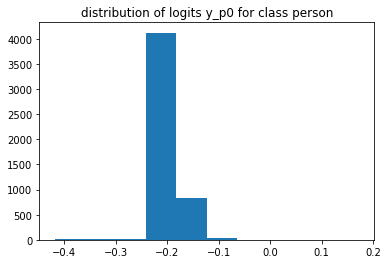

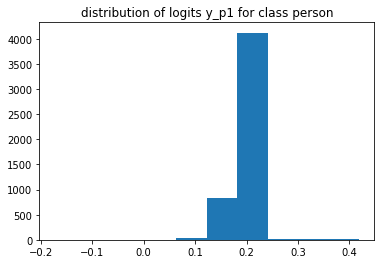

pottedplant


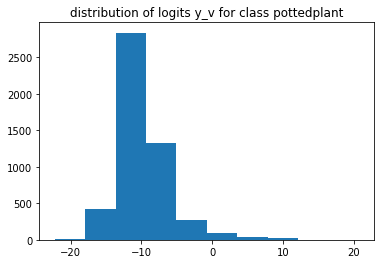

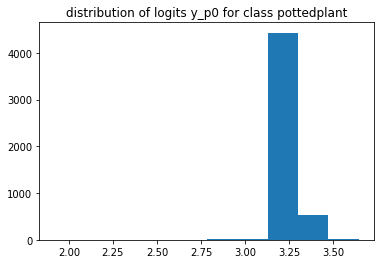

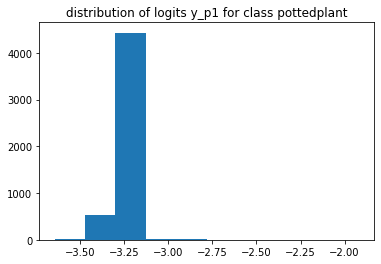

sheep


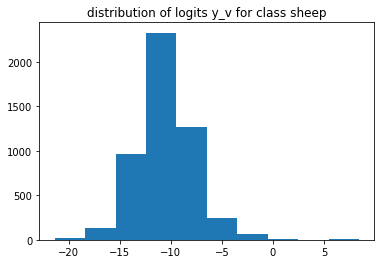

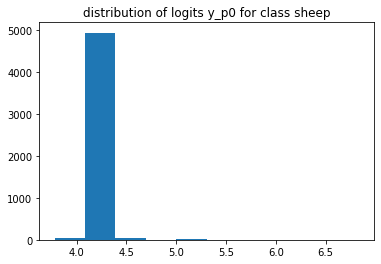

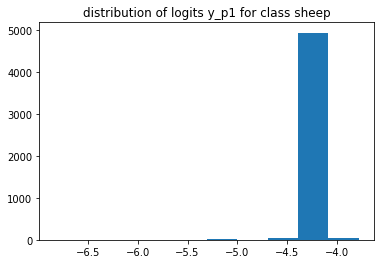

sofa


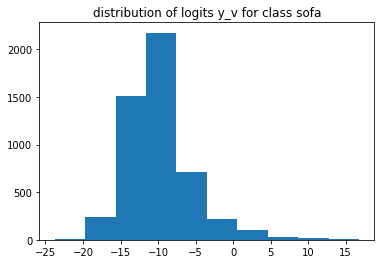

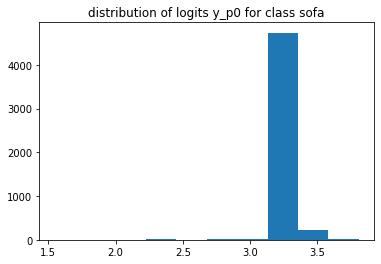

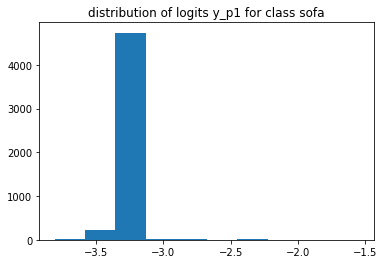

train


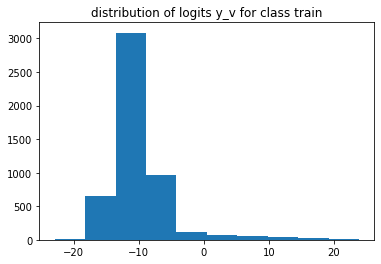

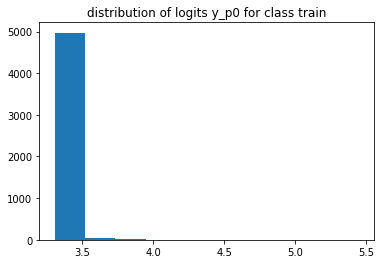

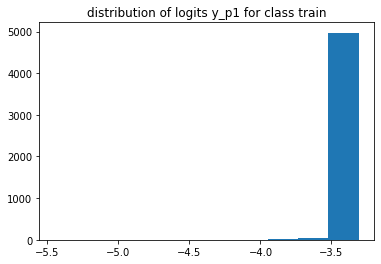

tvmonitor


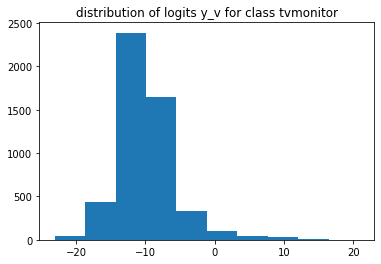

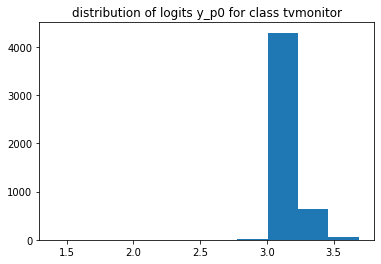

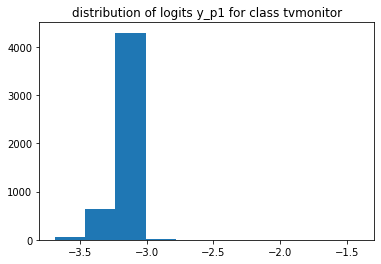

In [20]:
for i in range(nb_classes):
    cname = id2name[i]    
    print(cname)
    plt.hist(data_yv_logits[cname])
    plt.title('distribution of logits y_v for class %s' % cname)

    plt.show()
    
    plt.hist(data_yp0_logits[cname])
    plt.title('distribution of logits y_p0 for class %s' % cname)

    plt.show()
    
    plt.hist(data_yp1_logits[cname])
    plt.title('distribution of logits y_p1 for class %s' % cname)

    plt.show()

## exploration of contexts

In [29]:
# loading of the matrix
full_prior_path = os.path.join(data_dir, 'Annotations', 'prior_matrix_coco14_raw_100_1.json')
with open(full_prior_path, 'r') as f_matrix:
    full_prior_matrix = json.load(f_matrix)

In [30]:
len(full_prior_matrix['tr1'].keys())

82

In [31]:
id2short = {data['id']: data['short'] for data in class_info.values()}

In [36]:
def get_partial_contexts(current_short, nb=2):
    '''
    '''
    partial_contexts = list()
    shorts = copy.copy(list(id2short.values()))
    shorts.remove(current_short)

    for partial_combination in itertools.combinations(shorts, r=nb):
        for nb_combination in itertools.product([0, 1], repeat=nb):
            partial_contexts.append('%s%s_%s%s' % (partial_combination[0], nb_combination[0], partial_combination[1], nb_combination[1]))

    assert len(partial_contexts) == math.factorial(nb_classes - 1) / (math.factorial(nb) * math.factorial(nb_classes - 1 - nb)) * len(list(itertools.product([0, 1], repeat=nb)))
    return partial_contexts

In [52]:
count_total = 0
partial_data = defaultdict(dict)

# for all the classes (20)
for pascal_id, pascal_short in id2short.items():

    # for each possible context (171 * 4)
    for partial_context in get_partial_contexts(pascal_short):

        count_total += 1
        if count_total % 1000 == 0:
            print('done %s partial contexts' % count_total)

        partial_parts = partial_context.split('_')

        # retrieve relevant values from the raw matrix
        one_value = sum([val for fc, val in full_prior_matrix['%s1' % pascal_short].items() if any([fc_part in partial_parts for fc_part in fc.split('_')])])
        zero_value = sum([val for fc, val in full_prior_matrix['%s0' % pascal_short].items() if any([fc_part in partial_parts for fc_part in fc.split('_')])])

        partial_data['%s0' % pascal_short][partial_context] = zero_value
        partial_data['%s1' % pascal_short][partial_context] = one_value

done 1000 partial contexts
done 2000 partial contexts
done 3000 partial contexts
done 4000 partial contexts
done 5000 partial contexts
done 6000 partial contexts
done 7000 partial contexts
done 8000 partial contexts
done 9000 partial contexts
done 10000 partial contexts
done 11000 partial contexts
done 12000 partial contexts
done 13000 partial contexts


In [59]:
# printing of contexts
for classkey, context_data in partial_data.items():
    print('\n doing class key %s' % classkey)
    names = list(context_data.keys())
    values = list(context_data.values())

    sorted_indexes = np.argsort(values)
    ten_highest_values = [values[i] for i in sorted_indexes[-10:]]
    ten_lowest_values = [values[i] for i in sorted_indexes[:10]]
    
    ten_highest_contexts = [names[i] for i in sorted_indexes[-10:]]
    ten_lowest_contexts = [names[i] for i in sorted_indexes[:10]]
    
    print(ten_highest_values)
    print(ten_lowest_values)
    print(ten_highest_contexts)
    print(ten_lowest_contexts)
    
    # fig = plt.figure()
    # ax = fig.add_subplot(1, 1, 1)
    # ax.bar(names, values)
    # plt.title('partial context data for classkey %s' % classkey)



 doing class key ae0
[80537, 80537, 80537, 80537, 80537, 80538, 80538, 80539, 80539, 80539]
[2420, 3127, 3131, 3305, 3369, 3372, 3388, 3528, 3557, 3561]
['mo0_so0', 'bo0_ca0', 'so0_tr0', 'ho0_so0', 'sh0_tv0', 'bu0_ca0', 'ca0_tr0', 'co0_so0', 'sh0_so0', 'bu0_so0']
['co1_sh1', 'ho1_sh1', 'bo1_sh1', 'bi1_sh1', 'bc1_sh1', 'co1_ho1', 'bo1_co1', 'mo1_sh1', 'bi1_co1', 'sh1_tr1']

 doing class key ae1
[2243, 2243, 2243, 2243, 2243, 2243, 2243, 2243, 2243, 2243]
[1, 1, 2, 3, 3, 3, 3, 4, 4, 4]
['ch0_do0', 'bt0_sh0', 'bi0_do0', 'ho0_mo0', 'ch0_co0', 'bt0_co0', 'ca0_tr0', 'bc0_mo0', 'do0_tv0', 'bc0_bi0']
['co1_so1', 'sh1_so1', 'co1_sh1', 'ho1_so1', 'so1_tr1', 'ca1_so1', 'co1_ho1', 'ca1_sh1', 'co1_tr1', 'sh1_tr1']

 doing class key bc0
[80493, 80493, 80494, 80494, 80495, 80495, 80495, 80495, 80495, 80496]
[2374, 3064, 3102, 3215, 3269, 3274, 3324, 3325, 3421, 3487]
['so0_tr0', 'ae0_ca0', 'ca0_tr0', 'bu0_ca0', 'bu0_so0', 'sh0_so0', 'ae0_sh0', 'co0_so0', 'ae0_co0', 'ae0_so0']
['co1_sh1', 'ho1_sh1', 

In [58]:
test_a = [1, 2, 4, 6, 1, 2, 4]

np.argsort(test_a)

array([0, 4, 1, 5, 2, 6, 3])

## alpha diagrams

In [75]:
alpha2map = {
    0: 0.7109682534774191,
    0.1: 0.7109544444426388,
    0.2: 0.7109346886904145,
    0.3: 0.7108792567080935,
    0.4: 0.7108503547430158,
    0.5: 0.7107818417743182,
    1: 0.7106213269894613,
    10: 0.7033200798,
    50: 0.6345743659,
    100: 0.574897186
}


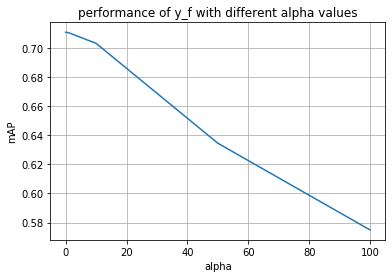

In [76]:

fig, ax = plt.subplots()
ax.plot(list(alpha2map.keys()), list(alpha2map.values()))

ax.set(xlabel='alpha', ylabel='mAP',
       title='performance of y_f with different alpha values')
ax.grid()

fig.savefig("test.png")
plt.show()

In [73]:
small_values_only = {
    0: 0.7109682534774191,
    0.1: 0.7109544444426388,
    0.2: 0.7109346886904145,
    0.3: 0.7108792567080935,
    0.4: 0.7108503547430158,
    0.5: 0.7107818417743182,
    1: 0.7106213269894613
}

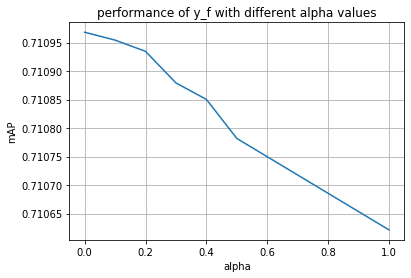

In [74]:

fig, ax = plt.subplots()
ax.plot(list(small_values_only.keys()), list(small_values_only.values()))

ax.set(xlabel='alpha', ylabel='mAP',
       title='performance of y_f with different alpha values')
ax.grid()

fig.savefig("test.png")
plt.show()

## default values

In [98]:
annotations_path = os.path.join(data_dir, 'Annotations', 'annotations_multilabel_trainval_partial_100_1.csv')
count_total = 0
counts = defaultdict(lambda: 0)

with open(annotations_path, 'r') as f_in:
    for line in f_in:
        count_total += 1
        
        parts = line.strip().split(',')
        
        for i, elt in enumerate(parts[1:]):
            assert len(parts[1:]) == 20
                    
            if elt == '1':
                counts[i] += 1
                    
                    
        

In [99]:
counts

defaultdict(<function __main__.<lambda>()>,
            {6: 713,
             4: 244,
             14: 2008,
             8: 445,
             17: 229,
             12: 287,
             11: 421,
             16: 96,
             5: 186,
             1: 243,
             0: 238,
             19: 256,
             2: 330,
             13: 245,
             15: 245,
             18: 261,
             10: 200,
             9: 141,
             3: 181,
             7: 337})

In [100]:
count_total

5011

In [101]:
for classid in sorted(counts.keys()):
    print('%s' % (counts[classid] / count_total)) 

0.04749550987826781
0.04849331470764318
0.0658551187387747
0.03612053482338855
0.04869287567351826
0.03711833965276392
0.14228696866892837
0.06725204549990021
0.0888046298144083
0.02813809618838555
0.039912193175014966
0.08401516663340651
0.057273997206146475
0.048892436639393334
0.40071841947715026
0.048892436639393334
0.019157852724007184
0.045699461185392136
0.05208541209339453
0.05108760726401916


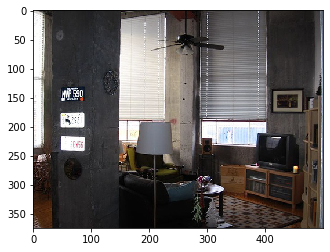

In [85]:
img_path = '/home/caleml/datasets/pascalvoc/VOCdevkit/VOC2007/JPEGImages/007702.jpg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

In [103]:
np.abs(-1)

1

In [1]:
a = [0, 1, 0, 0, 0]

In [2]:
a.replace(0, -1)

AttributeError: 'list' object has no attribute 'replace'

In [5]:
from sklearn import metrics

y_gt_val = [1, 1, 0, 0]
y_v_val1 = [0.7, 0.6, 0.2, 0.03]
y_v_val2 = [0.4, 0.6, 0.2, 0.03]
print(metrics.average_precision_score(y_gt_val, y_v_val1))
print(metrics.average_precision_score(y_gt_val, y_v_val2))

1.0
1.0
